## Проект 4. Прогнозирование вероятности дефолта заемщика.
### Еременко Виктория

### Задача: построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. 

### Импорт библиотек¶

In [67]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (7,5)

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,RobustScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.pipeline import Pipeline

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

In [8]:
# фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [9]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [10]:
# Функции для обработки данных и построения модели

def get_number_of_outliers(col):
    "Функция, которая выводит небольшую статистику по выбросам"
    
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    IQR = q3 - q1
    l_border = q1 - 1.5*IQR
    u_border = q3 + 1.5*IQR
     
    num_of_outl = data[col][(data[col] < l_border) | (data[col] > u_border)].count()
    print('Переменная:', col)
    print('Границы выбросов:', l_border, u_border)
    print('Количество выбросов', num_of_outl)
    print('* '*20)
    
def plot_cv_metrics(cv_metrics):
    """Функция для вывода метрик кроссвалидации на графике"""
    
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.4f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.4f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(8, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)
    
def train_validate(X, y):
    "Функция для обучения модели и вывода метрик качества модели"
    
    # Разбить данные на train/valid
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)
    
    # Привести числовые переменные к стандартному виду
    scaler = RobustScaler()
    scaler.fit_transform(X_train)
    scaler.transform(X_valid)
    
    # Oбучить модель
   
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_valid)[:,1]
    y_pred = model.predict(X_valid)

    # Посчитать метрики качества
    plot_confusion_matrix(model, X_valid, y_valid)
    print("ROC score:" , roc_auc_score(y_valid, probs))
    print('-' * 20)
    report = classification_report(y_valid, model.predict(X_valid), target_names=['No default', 'Default'])
    print('-' * 20)
    cv_metrics = cross_validate(model, X, y, scoring = 'f1', return_train_score = True)
    plot_cv_metrics(cv_metrics)
    print(report)

In [11]:
# Подгружаем данные (для локальной работы)
data = pd.read_csv("train.csv")
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [12]:
# Подгружаем данные (для работы на Kaggle)
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
#PATH_to_file = '/kaggle/input/sf-dst-scoring/'

#data_train = pd.read_csv(PATH_to_file+'train.csv')
#data_test = pd.read_csv(PATH_to_file+'test.csv')

In [13]:
# Для корректной обработки признаков сливаем тест и трейн в один датасет.
# Помечаем тренировочные и тестовые данные

data_train['Train'] = 1 
data_test['Train'] = 0 

data = data_train.append(data_test, sort=False).reset_index(drop=True) 

In [14]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
client_id           110148 non-null int64
app_date            110148 non-null object
education           109670 non-null object
sex                 110148 non-null object
age                 110148 non-null int64
car                 110148 non-null object
car_type            110148 non-null object
decline_app_cnt     110148 non-null int64
good_work           110148 non-null int64
score_bki           110148 non-null float64
bki_request_cnt     110148 non-null int64
region_rating       110148 non-null int64
home_address        110148 non-null int64
work_address        110148 non-null int64
income              110148 non-null int64
sna                 110148 non-null int64
first_time          110148 non-null int64
foreign_passport    110148 non-null object
default             73799 non-null float64
Train               110148 non-null int64
dtypes: float64(2), int64(12), object(6)

#### Описания полей
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

# EDA. Подготовка данных для модели

In [16]:
# Посмотрим количество пропусков. Пропуски есть только в переменной "уровень образования".
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

In [17]:
# посмотрим на количество уникальных значений для каждой переменной
data.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
Train                    2
dtype: int64

0.0    64427
1.0     9372
Name: default, dtype: int64
Процент случаев положительного класса: 13.0


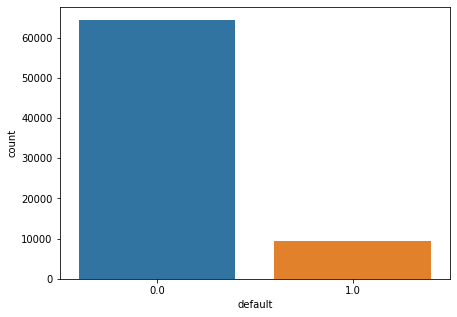

In [18]:
# Что нам надо предсказать
# Сразу видим что выборка не сбалансирована по классам
sns.countplot(data['default'])
print(data['default'].value_counts())
print('Процент случаев положительного класса:', round((data['default'].sum() / data['default'].count()) * 100))

In [19]:
# Разделим переменные по типам

# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'home_address','work_address', 'region_rating', 'sna', 'first_time']

# числовые переменные
num_cols = ['age', 'score_bki','decline_app_cnt', 'bki_request_cnt', 'income']

In [20]:
# Особняком стоит переменная "дата подачи заявки". Нужно перевести ее в числовой формат
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')

In [21]:
# Все данные собраны за период с 1 января по 30 апреля 2014 года
start = data['app_date'].min()
end = data['app_date'].max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [22]:
# Вводим новый признак - номер дня с 1 января 2014 года до обращения в банк
data['days'] = (data['app_date'] - start).dt.days.astype('int')

In [23]:
data['month'] = data['app_date'].dt.month.astype('int')

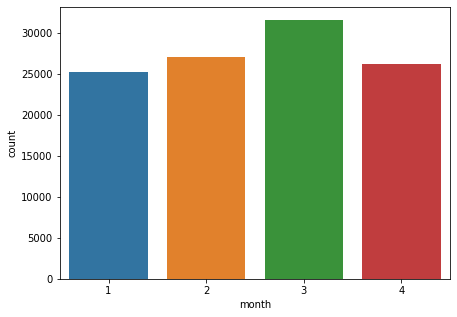

In [24]:
sns.countplot(data['month'])

In [25]:
# Удаляем колонку с датами
data.drop('app_date', axis = 1, inplace = True)

In [26]:
# Добавим новые колонки в списки числовых и категориальных переменных
num_cols.append('days')
cat_cols.append('month')

### Посмотрим на бинарные переменные

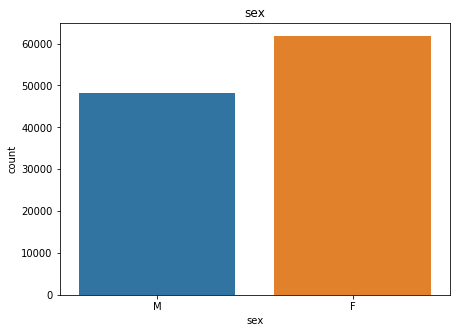

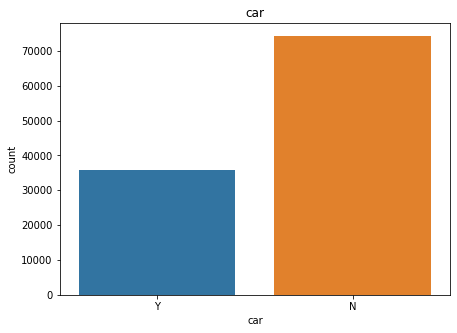

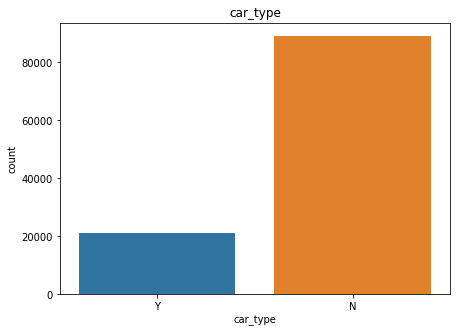

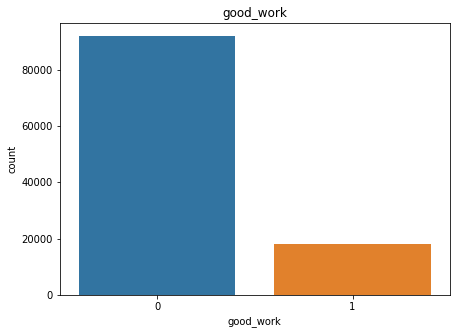

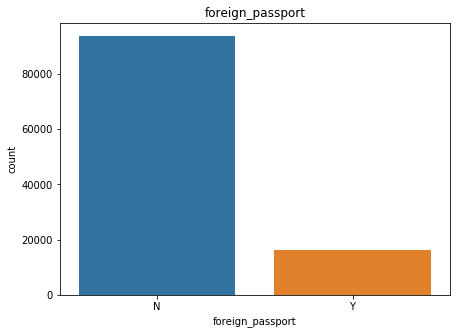

In [27]:
for i in bin_cols:
    plt.figure()
    sns.countplot(data[i])
    plt.title(i)
    plt.show()

Переведем переменные в числовые значения

In [28]:
# Переменную "пол" обработаем отдельно и выведем кодировку значений
label_encoder = LabelEncoder()

data['sex'] = label_encoder.fit_transform(data['sex'])
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [29]:
# Обработаем остальные бинарные переменные и выведем кодировку значений
label_encoder_2 = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder_2.fit_transform(data[column])
    
print(dict(enumerate(label_encoder_2.classes_)))

{0: 'N', 1: 'Y'}


### Посмотрим на категориальные переменные

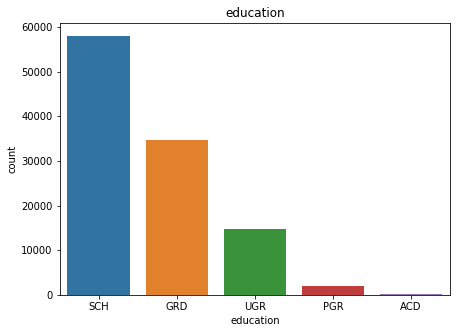

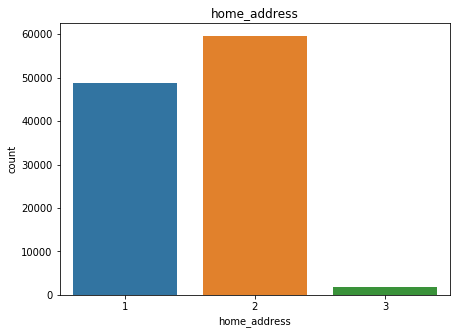

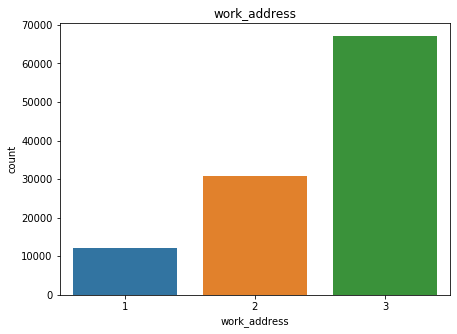

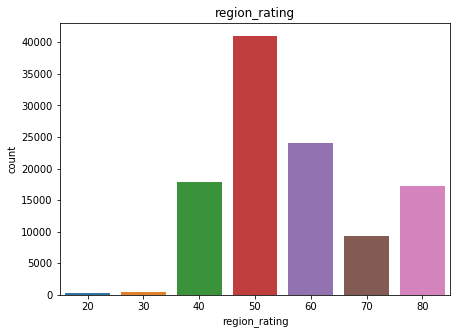

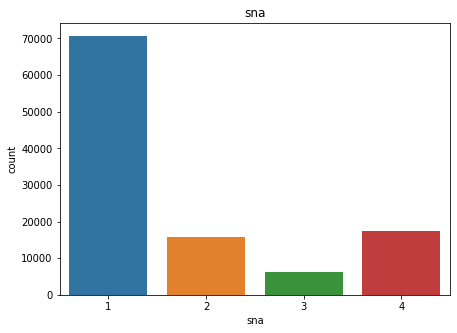

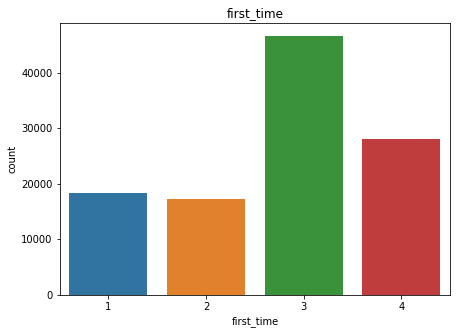

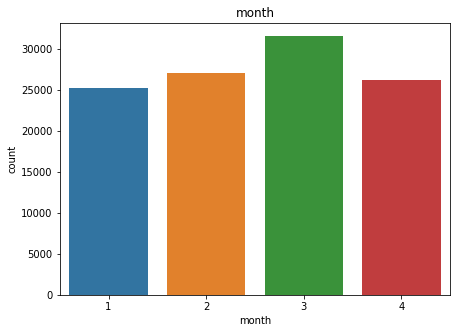

In [30]:
for i in cat_cols:
    plt.figure()
    sns.countplot(data[i])
    plt.title(i)
    plt.show()

#### Заполнение пропущенных значений
Пропуски (478) есть только в переменной "уровень образования". Т.к. при заполнении анкет на получение кредита пропуски не допускаются, рискну предположить, что пропущенные значения имеют смысл и их стоит обозначить отдельно. 


In [31]:
# Обозначим отдельно пропущенные значения
data['education'] = data['education'].fillna('missing')  

In [32]:
# Перекодируем данные об обучении в цифры
le2 = LabelEncoder()
le2.fit(data['education'])
data['education'] = le2.transform(data['education'])
print(dict(enumerate(le2.classes_)))

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR', 5: 'missing'}


In [33]:
# Создадим фиктивные переменные на основе категориальных колонок
ohe = OneHotEncoder(sparse = False)
cat_cols_encoded_data = ohe.fit_transform(data[cat_cols].values)
cat_cols_encoded_features = ohe.get_feature_names(cat_cols)
data[cat_cols_encoded_features] = pd.DataFrame(cat_cols_encoded_data)

In [34]:
# Удалим старые колонки с категориальными переменными
data.drop(cat_cols, axis = 1, inplace = True)

In [35]:
# Проверяем
data.head()

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,...,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,month_1,month_2,month_3,month_4
0,25905,1,62,1,1,0,0,-2.008753,1,18000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,63161,0,59,0,0,0,0,-1.532276,3,19000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25887,1,25,1,0,2,0,-1.408142,1,30000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,16222,0,53,0,0,0,0,-2.057471,2,10000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,101655,1,48,0,0,0,1,-1.244723,1,30000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [36]:
# Категориальные колонки превратились в бинарные. Обновим список бинарных колонок
bin_cols = bin_cols + list(cat_cols_encoded_features)

### Посмотрим на числовые переменные

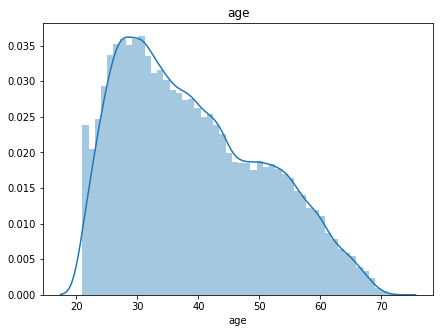

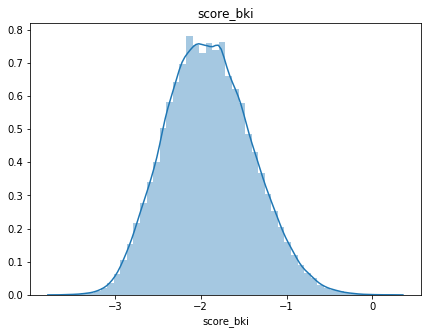

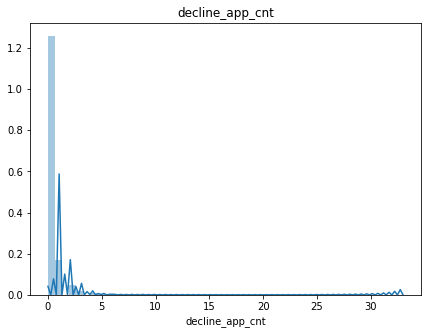

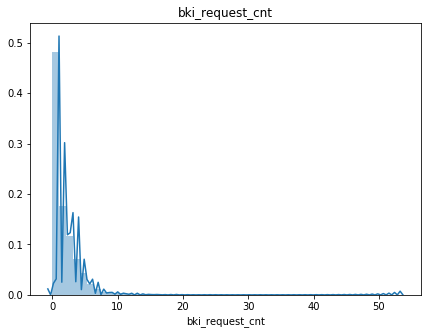

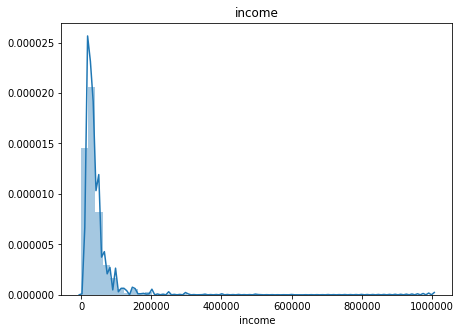

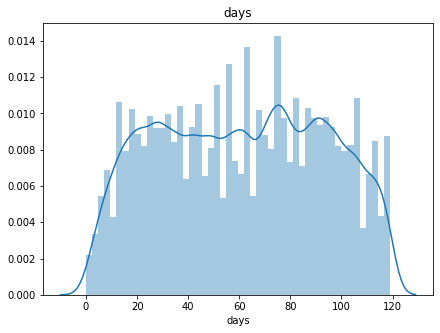

In [37]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i])
    plt.title(i)
    plt.show()

In [38]:
# Посмотрим статистику по выбросам
for col in num_cols:
    get_number_of_outliers(col)

Переменная: age
Границы выбросов: 3.0 75.0
Количество выбросов 0
* * * * * * * * * * * * * * * * * * * * 
Переменная: score_bki
Границы выбросов: -3.299251946250001 -0.5290698762499992
Количество выбросов 518
* * * * * * * * * * * * * * * * * * * * 
Переменная: decline_app_cnt
Границы выбросов: 0.0 0.0
Количество выбросов 18677
* * * * * * * * * * * * * * * * * * * * 
Переменная: bki_request_cnt
Границы выбросов: -4.5 7.5
Количество выбросов 2636
* * * * * * * * * * * * * * * * * * * * 
Переменная: income
Границы выбросов: -22000.0 90000.0
Количество выбросов 7000
* * * * * * * * * * * * * * * * * * * * 
Переменная: days
Границы выбросов: -51.0 173.0
Количество выбросов 0
* * * * * * * * * * * * * * * * * * * * 


В переменной "возраст" выбросов нет, распределение немного смещенное, но в целом близкое к нормальному. 
Переменная "скоринговый балл" выглядит так, как будто с ней уже провели какие-то преобразования. Распределение у нее нормальное. Трогать ее не будем. 

In [39]:
# Логарифмируем остальные переменные, чтобы сделать распределения более "нормальными"
for col in num_cols[2:]:
    data[col] = np.log(data[col] + 1)

In [40]:
# Посмотрим на количество выбросов после логарифмирования
for col in num_cols[2:]:
    get_number_of_outliers(col)

Переменная: decline_app_cnt
Границы выбросов: 0.0 0.0
Количество выбросов 18677
* * * * * * * * * * * * * * * * * * * * 
Переменная: bki_request_cnt
Границы выбросов: -2.0794415416798357 3.465735902799726
Количество выбросов 15
* * * * * * * * * * * * * * * * * * * * 
Переменная: income
Границы выбросов: 8.590378193705899 12.092136480586621
Количество выбросов 2609
* * * * * * * * * * * * * * * * * * * * 
Переменная: days
Границы выбросов: 2.0661868060450064 5.959983388901421
Количество выбросов 2311
* * * * * * * * * * * * * * * * * * * * 


Логарифмирование существенно сократило количество выбросов в переменных "доход" и "количество обращений в БКИ". Для переменной "количество отклоненных заявок" по-прежнему все значения выше нуля (18677) являются выбросами.

В переменной "количество дней с начала года до обращения в банк" после логарифмирования появились выбросы, но решила все равно логарифмировать, тк это положительно сказалось на метриках...

#### Работа с выбросами
Пока что с выбросами делать ничего не буду, тк они все явно неслучайные, такие значения действительно могут быть. 

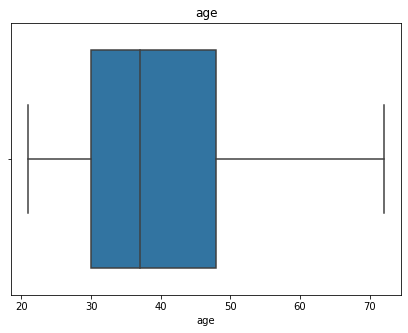

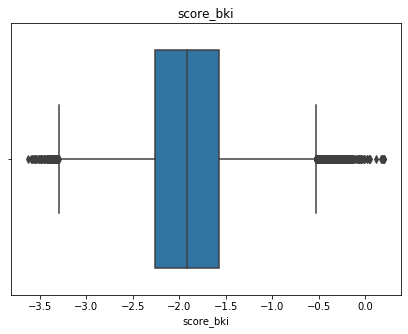

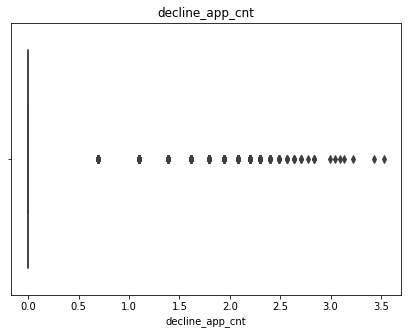

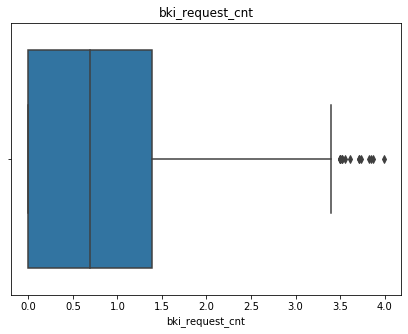

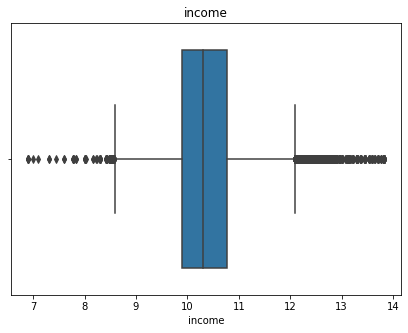

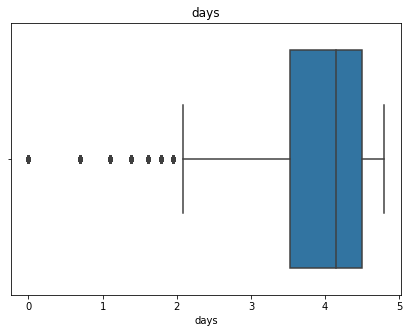

In [41]:
# Для оценки выбросов построим боксплоты
for i in num_cols:
    plt.figure()
    sns.boxplot(data[i])
    plt.title(i)
    plt.show()

In [42]:
#data['decline_app_cnt_outl'] = 1 * (data['decline_app_cnt'].values > 0)
#bin_cols.append('decline_app_cnt_outl')

### Для оценки значимости бинарных переменных 
будем использовать функцию mutual_info_classif из библиотеки sklearn. 

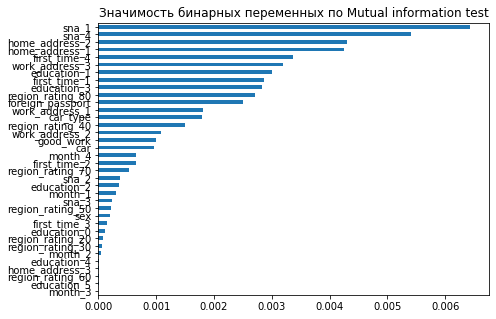

In [43]:
# оценка важности бинарных  переменных на тренировочной выборке
imp_cat = pd.Series(mutual_info_classif(data[bin_cols][data['Train'] == 1], data['default'][data['Train'] == 1],
                                     discrete_features =True, n_neighbors=7), index = bin_cols)
imp_cat.sort_values(inplace = True)

imp_cat.plot(kind = 'barh', title = 'Значимость бинарных переменных по Mutual information test')

#### Очень большой вопрос, как это интерпретировать? 
В любом случае, удаление переменных, у которых показатель близок к нулю, не привело к улучшению качества модели. Так что в дальнейшем я их не удаляла.  

In [44]:
# Удалим незначимые признаки
#data.drop(['education_4', 'education_5', 'home_address_3'], axis = 1, inplace = True)

#### Оценка важности числовых переменных

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). 
Основу процедуры составляет обобщение результатов 
двух выборочных t-тестов для независимых выборок (2-sample t). 
В качестве меры значимости мы будем использовать значение f-статистики. 
Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, 
и тем важнее данный признак для нашей линейной модели.

In [45]:
imp_num = pd.Series(f_classif(data[num_cols][data['Train'] == 1], data['default'][data['Train'] == 1])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num

age                  46.166168
days                 87.429117
income              214.790527
bki_request_cnt     457.591760
decline_app_cnt    1152.937317
score_bki          2341.599450
dtype: float64

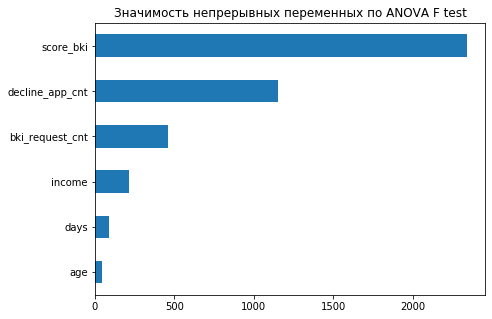

In [46]:
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test')

Самый важный признак для предсказания дефолта - кредитный рейтинг

### Оценка корреляций

(6.0, 0.0)

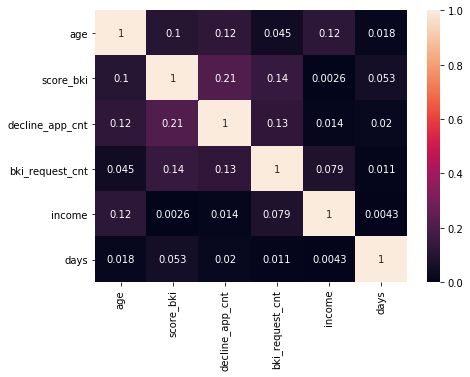

In [47]:
ax = sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)


Числовые признаки не скоррелированы между собой. Значит, ничего лишнего здесь нет, все подойдет для построения модели

Поскольку линейной зависимости между числовыми признаками нет, можно предположить нелинейную зависимость или совместное действие разных факторов. Поэтому имеет смысл сгенерировать полиномиальные признаки. 

Этот ход тоже, к сожалению, к улучшению модели не привел, так что не стала им пользоваться. 

In [48]:
#poly = PolynomialFeatures()
#X_poly = poly.fit_transform(data[num_cols].values)
#poly_feature_names = poly.get_feature_names(num_cols)
#data[poly_feature_names] = pd.DataFrame(X_poly, columns = poly_feature_names)

### Обучение модели. Валидация. Метрики качества. 

In [49]:
# Выделим тестовую часть данных 
train_data = data.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = data.query('Train == 0').drop(['Train', 'client_id'], axis=1)

In [50]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 0 to 73798
Data columns (total 43 columns):
sex                 73799 non-null int64
age                 73799 non-null int64
car                 73799 non-null int32
car_type            73799 non-null int32
decline_app_cnt     73799 non-null float64
good_work           73799 non-null int64
score_bki           73799 non-null float64
bki_request_cnt     73799 non-null float64
income              73799 non-null float64
foreign_passport    73799 non-null int32
default             73799 non-null float64
days                73799 non-null float64
education_0         73799 non-null float64
education_1         73799 non-null float64
education_2         73799 non-null float64
education_3         73799 non-null float64
education_4         73799 non-null float64
education_5         73799 non-null float64
home_address_1      73799 non-null float64
home_address_2      73799 non-null float64
home_address_3      73799 non-null float64


In [51]:
# Выделяем матрицу признаков и целевую переменную
X = train_data.drop(['default'], axis = 1).values
y = train_data['default'].values

In [52]:
X.shape

(73799, 42)

In [53]:
# Т.к. классы, которые нам нужно различать, несбалансированы, установим 
# для параметра class_weight значение 'balanced' (модель дает разные веса классам)
model = LogisticRegression(class_weight = 'balanced', random_state=RANDOM_SEED )

ROC score: 0.7442443351785131
--------------------
--------------------
[train] F1-score = 0.3420 +/- 0.00
[valid] F1-score = 0.3418 +/- 0.01
              precision    recall  f1-score   support

  No default       0.94      0.67      0.78     12933
     Default       0.23      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760



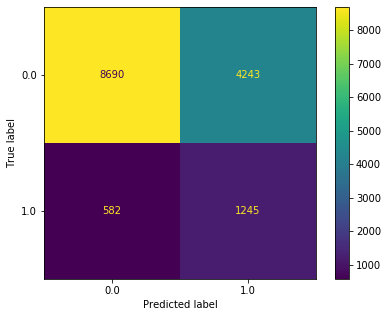

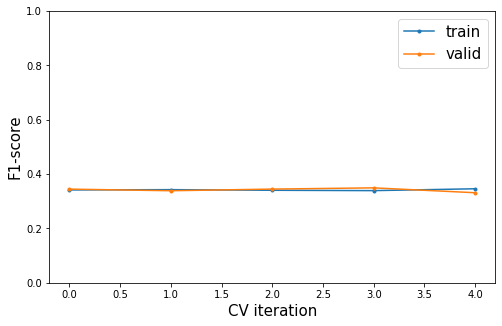

In [54]:
train_validate(X, y)

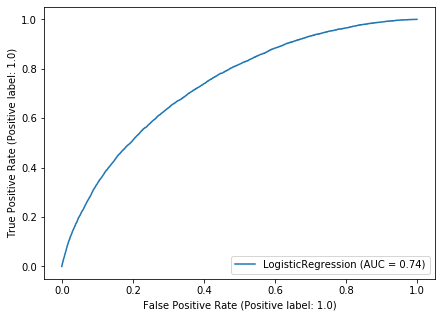

In [66]:
plot_roc_curve(model, X_train, y_train)

#### Настройка гиперпараметров

Попробуем улучшить показатели модели.
Поиск по сетке закомментировала, тк выполняется он довольно долго.

In [55]:
# Поиск по сетке. Пока что решила ограничиться величиной штрафа. Регуляризация l2 применяется в модели по умолчанию. 

#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

#scaler = RobustScaler()
#model = LogisticRegression(class_weight = 'balanced', random_state=RANDOM_SEED)
#pipe = Pipeline(steps=[('scaler', scaler), ('model', model)])


#param_grid = {'model__C': np.logspace(-3,1,200)}


#search = GridSearchCV (pipe, param_grid, scoring='roc_auc', n_jobs=-1, verbose = 1, cv=5)
#search.fit(X_train, y_train)

#print(search.best_params_)
#print(search.best_score_)

In [56]:
# модель с применением лучшего параметра
model = LogisticRegression(C=0.08119844993184012, class_weight = 'balanced', random_state=RANDOM_SEED)

ROC score: 0.7443481500864778
--------------------
--------------------
[train] F1-score = 0.3419 +/- 0.00
[valid] F1-score = 0.3417 +/- 0.01
              precision    recall  f1-score   support

  No default       0.94      0.67      0.78     12933
     Default       0.23      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760



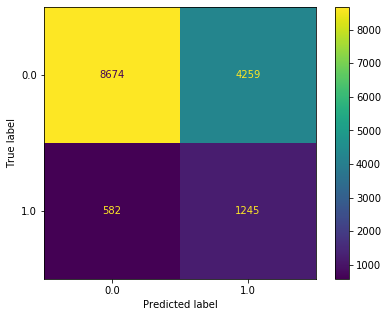

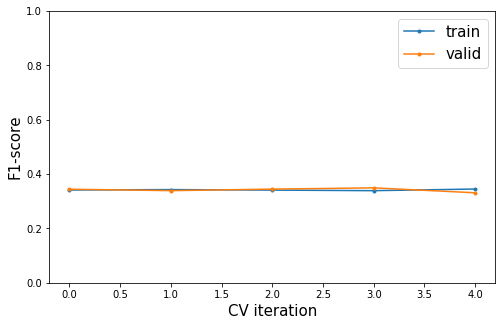

In [57]:
train_validate(X,y)

Видим, что roc_auc незначительно улучшился, хотя и принципиальной разницы нет. 

### Выводы

Полученная модель справляется с задачей лучше, чем случайное угадывание, при котором roc_auc был бы равен 0.5. Признаков переобучения я тоже не вижу - f1 на обучении и валидации сильно не отличаются. Однако сам этот показатель довольно низкий, так что модель скорее недообучена. 

Модель может правильно предсказать класс примерно для 67-68% представителей каждого класа (recall 0,67-0,68 - одинаковый для обоих классов). Тем не менее precision гораздо выше для класса надежных заемщиков (0.94), чем ненадежных (0.23). То есть, если модель предсказала, что заемщик надежный, мы можем быть очень уверены, что это именно так и есть. Если модель предсказывает, что у заемщика высок риск дефолта, то ситуация неочевидная....

### Submission

In [58]:
train_data = data.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = data.query('Train == 0').drop(['Train'], axis=1)

In [59]:
X_train=train_data.drop(['default'], axis=1).values
y_train = train_data['default'].values
X_test = test_data.drop(['default', 'client_id'], axis=1).values

In [60]:
# проверяем
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 44), (73799, 43), (73799, 42), (73799,), (36349, 42))

In [61]:
# Стандартизуем данные
scaler = RobustScaler() 
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 1.        , -0.44444444,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.11111111,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.72222222,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.        , -0.33333333,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        , -0.55555556,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.05555556,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

In [62]:
model = LogisticRegression(C=0.08119844993184012, class_weight = 'balanced', random_state=RANDOM_SEED)
model.fit(X_train, y_train)

LogisticRegression(C=0.08119844993184012, class_weight='balanced',
                   random_state=42)

In [63]:
y_pred_prob = model.predict_proba(X_test)[:,1]


submit = pd.DataFrame(test_data['client_id'])
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)